## Imports

In [49]:
from constants import OPENAI_API_KEY
import csv
from dotenv import load_dotenv, find_dotenv
import matplotlib.pyplot as plt
from openai import OpenAI
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [50]:
DEFAULT_FONT = 14

## Data Setup and Split

In [51]:
# Load dataset
dataPath = './feedback-prize-english-language-learning/train.csv'
df_all = pd.read_csv(dataPath)

# Create essay average scores to simplify dataset comparisons
categories = df_all.columns[2:8]
predicted_columns = ['p_' + category for category in categories]
actual_columns = ['a_' + category for category in categories]
df_all['Average'] = df_all[categories].mean(axis=1).round(1)

In [52]:
# Split data into Train, Validation and Test sets
df_train, df_holdout = train_test_split(
    df_all, test_size=0.2, random_state=42)
df_val, df_test = train_test_split(
    df_holdout, test_size=0.5, random_state=42)

# Create summary of all three datasets
train_desc = df_train['Average'].describe()
val_desc = df_val['Average'].describe()
test_desc = df_test['Average'].describe()

summary = pd.concat([train_desc, val_desc, test_desc], axis=1)
summary.columns = ['Train', 'Validate', 'Test']

print("\nSummary of Averages for each dataset:")
pd.set_option('display.float_format', lambda x: '%0.1f' % x)
display(summary)


Summary of Averages for each dataset:


,Train,Validate,Test
count,3128.0,391.0,392.0
mean,3.1,3.1,3.1
std,0.6,0.5,0.6
min,1.0,1.0,1.4
25%,2.7,2.7,2.7
50%,3.1,3.1,3.1
75%,3.5,3.4,3.5
max,5.0,4.6,4.8


## Generate Prompts

Function to generate k-shot prompts from example essays and an essay to evaluate.

In [53]:
def generate_prompt(scored_essay, example_essays=[], example_scores=[]):

    if len(example_essays) != len(example_scores):
        raise ValueError("Number of example essays and scores provided must match")

    INSTRUCTIONS = f"""Score the following essay in these categories: cohesion, syntax, vocabulary, phraseology, grammar, conventions. 
    Return only a JSON object with category scores between 1.0 and 5.0 is 0.5 increments. Do not include newlines or any other characters."""
    EXAMPLE_PREFIX = f""" Here is an example essay surrounded by triple backticks followed by scores: ```"""
    SCORED_ESSAY_PREFIX = f""" Essay for you to score surrounded by triple backticks: ```"""
    CATEGORIES = categories

    prompt = INSTRUCTIONS

    for e_ind, example in enumerate(example_essays):
        prompt += EXAMPLE_PREFIX
        prompt += example

        scores = "``` Score: "
        for s_ind, score in enumerate(example_scores[e_ind]):
            scores = scores + CATEGORIES[s_ind] + ": " + str(score) + ", "
        
        prompt += scores
    
    prompt += SCORED_ESSAY_PREFIX
    prompt += scored_essay
    prompt += "```"

    return prompt

Function to get completions for prompts to ChatGPT

In [54]:

client = OpenAI(
    api_key=OPENAI_API_KEY
)

def get_completion(prompt, model="gpt-3.5-turbo"):

    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        model=model,
    )

    return chat_completion.choices[0].message.content

Conversion of JSON output from ChatGPT to a list of scores to be used for evalutation.

In [55]:
import json

def convert_json_to_list(json_input):
    try:
        # Strip everything before the first '{' and after the last '}'
        json_input = json_input[json_input.find("{"):]
        json_input = json_input[:json_input.rfind("}") + 1]

        data = json.loads(json_input)
        values = list(data.values())
        return values
    except json.JSONDecodeError:
        print("Invalid JSON input")
        return []

Given an input file of essays, generate prompts for each essay and get completions from ChatGPT for predicted scores. 

In [56]:
def collect_results(model, filename, example_essays=[], example_scores=[]):
    # Create file to record results if not yet created
    if not os.path.exists(filename):
        with open(filename, 'w') as csvfile:
            header = ['text_id'] + actual_columns + predicted_columns
            csv.writer(csvfile).writerow(header)

    #Get the next row needed to be processed
    with open(filename, 'r') as outfile:
        start = len(list(csv.reader(outfile))) - 1

    end = len(df_test) - 1

    for idx in tqdm(range(start, end)):
        id = df_test.iloc[idx]['text_id']
        essay = df_test.iloc[idx]['full_text']
        actual_scores = list(df_test.iloc[idx][categories].values)
        predicted_scores = convert_json_to_list(
            get_completion(
                generate_prompt(essay, example_essays=example_essays, example_scores=example_scores),
                model=model
            )
        )

        with open(filename, 'a') as outfile:
            writer = csv.writer(outfile)
            writer.writerow([id] + actual_scores + predicted_scores)

Get an individual score from a single essay in the list. Useful for when you want to evaluate only a single essay.

In [57]:
def get_individual_score(text_id, model="gpt-3.5-turbo-1106", example_essays = [], example_scores = []):
    target_text = df_test['full_text'][df_test['text_id'] == text_id]
    scores = get_completion(generate_prompt(target_text.values[0], example_essays=example_essays, example_scores=example_scores),
                            model=model)
    print(scores)
    print(convert_json_to_list(scores))

Select example essays to use for k-shot prompting.  

For one shot prompting a single essay with the score closest to the average of 3 is selected.

For five shot prompting essays with scores closest to the average of 1, 2, 3, 4, and 5 are selected.

In [58]:
def get_example_essays(targets, df):
    example_essays = []
    example_scores = []
    for target in targets:
        example = df.iloc[(df['Average'] - target).abs().argmin()]
        example_essays.append(example['full_text'])
        example_scores.append(example[categories].values.tolist())
    return example_essays, example_scores

five_shot_essays, five_shot_scores = get_example_essays([1, 2, 3, 4, 5], df_train)
one_shot_essay, one_shot_scores = get_example_essays([3], df_train) 

## Scoring Essays with ChatGPT

Collect results from ChatGPT for each k-shot prompt and the essay to evaluate. Examples are commented out by default, uncomment to run.

In [59]:
#collect_results('gpt-3.5-turbo-1106', "GPT3.5-0-Shot-1106.csv")
#collect_results('gpt-3.5-turbo-1106', "GPT3.5-1-Shot-1106.csv", example_essays=one_shot_essay, example_scores=one_shot_scores)
#collect_results('gpt-3.5-turbo-1106', "GPT3.5-5-Shot-1106.csv", example_essays=five_shot_essays, example_scores=five_shot_scores)

#collect_results('gpt-4-1106-preview', "GPT4-0-Shot-1106.csv")
#collect_results('gpt-4-1106-preview', "GPT4-1-Shot-1106.csv", example_essays=one_shot_essay, example_scores=one_shot_scores)
#collect_results('gpt-4-1106-preview', "GPT4-5-Shot-1106.csv", example_essays=five_shot_essays, example_scores=five_shot_scores)


## Analyze Results

In [60]:
# Function to calculate loss
def analyze_results(filename):

    title = filename.rsplit('.', 1)[0][:-5]

    df = pd.read_csv(filename)

    df['a_overall'] = df[actual_columns].mean(axis=1)
    df['p_overall'] = df[predicted_columns].mean(axis=1)
    
    # Dataframe of individual category scores
    df_RMSE = pd.DataFrame(columns=['Category', title])

    all_categories = categories.values.tolist()

    for category in all_categories:
        y_true = df['a_' + category]
        y_pred = df['p_' + category]
        df_RMSE.loc[len(df_RMSE)] = [category, mean_squared_error(y_true, y_pred, squared=False)]
    
    # Insert average RMSE as first row
    overall_average = df_RMSE[title].mean()
    new_row = {'Category': 'overall', title: overall_average}
    new_row_df = pd.DataFrame(new_row, index=[0])
    df_RMSE = pd.concat([new_row_df, df_RMSE]).reset_index(drop=True)

    return df_RMSE, df

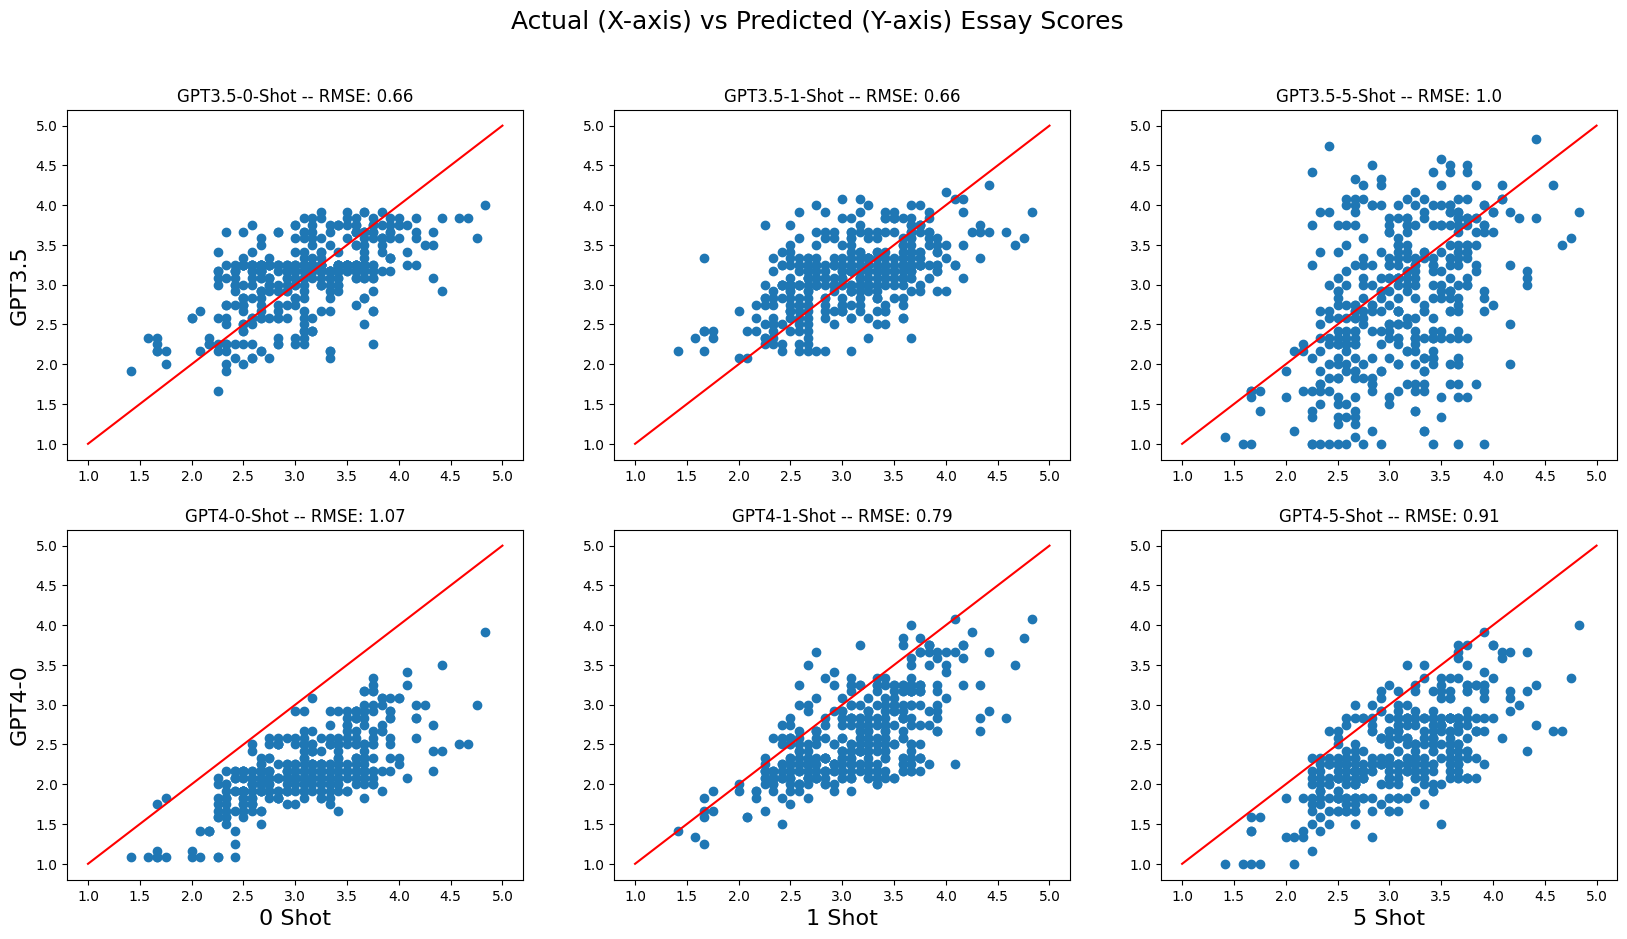

In [62]:
evaluations = ["GPT3.5-0-Shot", "GPT3.5-1-Shot", "GPT3.5-5-Shot", "GPT4-0-Shot", "GPT4-1-Shot", "GPT4-5-Shot"]

MIN_SCORE = 1
MAX_SCORE = 5

fig, axes = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle('Actual (X-axis) vs Predicted (Y-axis) Essay Scores', fontsize=DEFAULT_FONT + 4)

for i, evaluation in enumerate(evaluations):
    df_RMSE, df = analyze_results(evaluation + '-1106.csv')
    plot_row = i // 3
    plot_col = i % 3
    axes[plot_row, plot_col].scatter(df['a_overall'], df['p_overall'])
    axes[plot_row, plot_col].plot([MIN_SCORE, MAX_SCORE], [MIN_SCORE, MAX_SCORE], color='red') 
    axes[plot_row, plot_col].set_title(evaluation + " -- RMSE: " + str(df_RMSE[evaluation][0].round(2)))

    if plot_row == 1:  # Set x-axis label for bottom row
        axes[plot_row, plot_col].set_xlabel(evaluations[i][-6] + ' Shot', fontsize=DEFAULT_FONT + 2)

    if plot_col == 0:  # Set y-axis label for left column
        axes[plot_row, plot_col].set_ylabel(evaluations[i][:6], fontsize=DEFAULT_FONT + 2)

plt.show()